## This notebook functions for downstream processing of SNP-based genotyping
This notebook should be run after AlleleIntegrator. Cells 1-4 of this notebook are important for creating the bed file used for samtools-sn-pb.sh
Downstream are file conversions, zygosity sampling and heatmap visualizations

In [ ]:
### import all the necessary packages ###
import sys # system
import pandas as pd # dataframes
import seaborn as sns # plots
import matplotlib.pyplot as plt # plots
import scipy.sparse as sp
from scipy.sparse import csr_matrix # matrices
import os # system
import glob # global system
from os import listdir
from os.path import isfile, join
import random # random numbers
import numpy as np # numbers
import itertools # run iterations quickly
from collections import defaultdict # dictionaries
print(sys.executable) # what is being used

/software/isg/languages/Python/Python-3.11.10-jupyter/exec/bin/python3


In [ ]:
### set base directory
base_dir = "/lustre/scratch126/casm/team274sb/lr26/allele-integrator-pbfix/GenotypingResults/"

In [ ]:
### define file path
patient_file = base_dir + "patient-bulk-DNA_genotypeCheck.tsv"
### load the file into a df without the header
patient_df = pd.read_csv(patient_file, sep="\t", header=None) 
# print first few rows
print(patient_df.head())

   0      1  2  3   4  5   6
0  1  17365  0  5   0  0   5
1  1  17385  4  0  10  0  14
2  1  69270  0  0   0  0   0
3  1  69511  0  0   0  0   0
4  1  69761  0  0   0  0   0


In [ ]:
# select first two cols (chr and pos) using iloc
bed_df = df.iloc[:, [0, 1]].copy()  # column 1 = 'chr', 2 = 'pos'
# ensure chromosome names are prefixed (they currently were not)
bed_df.iloc[:, 0] = "chr" + bed_df.iloc[:, 0].astype(str)
# convert 'pos' to the bed format, start-end 0-1
bed_df['start'] = bed_df.iloc[:, 1]-1    # bed end is 1-based
bed_df['end'] = bed_df.iloc[:, 1]
# now keep only 'chr', 'start', 'end' columns
bed_df = bed_df.iloc[:, [0, 2, 3]]
# save as the BED file (no headers, no index) to be used in sampling
bed_df.to_csv("patient_output.bed", sep="\t", index=False, header=False)

In [ ]:
### NOW RUN the samtools-sn-pb.sh script, generating vcf files for all samples including long read ###

In [ ]:
### the compute_zygosity_similarity function ###
def compute_zygosity_similarity(file1, file2):
    """
    this fcn computes similarity between two files based on shared zygosity
    (homozygous or heterozygous) not only the raw AFs

    it accepts paths to two files - df1 and df2.

    it returns a similarity score
    """
    # read files into pandas as separate dfs defining column names - note that multiple freq can be present
    df1 = pd.read_csv(file1, sep="\t", header=None,
                      names=["CHROM", "POS", "REF", "ALT", "AD", "REF_FREQ", "ALT_FREQ", "OTHER_FREQ", "OTHER_FREQ1"])

    df2 = pd.read_csv(file2, sep="\t", header=None,
                      names=["CHROM", "POS", "REF", "ALT", "AD", "REF_FREQ", "ALT_FREQ", "OTHER_FREQ", "OTHER_FREQ1"])

    # ensure to use the chrom and pos which are the same for both the files
    merged_df = pd.merge(df1, df2, on=["CHROM", "POS"], suffixes=("_file1", "_file2"))

    # if there are NaN values, fill with 0
    merged_df.fillna(0, inplace=True)

    # determine the most abundant AF at each site using max
    merged_df["MAF_file1"] = merged_df[["REF_FREQ_file1", "ALT_FREQ_file1", "OTHER_FREQ_file1"]].max(axis=1)
    merged_df["MAF_file2"] = merged_df[["REF_FREQ_file2", "ALT_FREQ_file2", "OTHER_FREQ_file2"]].max(axis=1)

    # then define zygosity categories: homozygous (>= 0.9 or <= 0.1) and heterozygous
    # note that this will work because if it is heterozygous we are still getting max of around 0.5
    # also accounts for whole chromosomal copy number changes in tumor samples
    def determine_zygosity(freq):
        if freq >= 0.9 or freq <= 0.1:
            return "HOMO"
        else:
            return "HET"
    ### now use the determin_zygosity function across all positions in both files generating zygosity file1,2
    merged_df["ZYGOSITY_file1"] = merged_df["MAF_file1"].apply(determine_zygosity)
    merged_df["ZYGOSITY_file2"] = merged_df["MAF_file2"].apply(determine_zygosity)

    # then compute similarity as proportion of positions with matching zygosity
    # similarity score will be given as the shared zygosity divided by total positions
    # because there may be a different no of positions sampled for the downsampled sc/sn RNA files
    shared_zygosity = (merged_df["ZYGOSITY_file1"] == merged_df["ZYGOSITY_file2"]).sum()
    total_positions = len(merged_df)

    similarity_score = shared_zygosity / total_positions

    return similarity_score


In [ ]:
# here I am defining all the files which I used for the samtools sampling #
file1 = base_dir + "patient_fin.vcf"
file2 = base_dir + "s1A01_fin.vcf"
file3 = base_dir + "s1A02_fin.vcf"
file4 = base_dir + "s2B01_fin.vcf"
file5 = base_dir + "s1B01_fin.vcf"
file6 = base_dir + "s1C01_fin.vcf" ### wops I have flipped the 1C01 and 1B02
file7 = base_dir + "s1B02_fin.vcf" ### wops I have flipped the 1C01 and 1B02 
file8 = base_dir + "mom_fin.vcf"

In [ ]:
## here I am computing the pairwise similarity score between them and printing it nicely ##
similarity_score = compute_zygosity_similarity(file1, file2)
print(f"Shared zygosity patient tumor WGS - 1A01 patient tumor: {similarity_score:.4f}")
similarity_score1 = compute_zygosity_similarity(file1, file3)
print(f"Shared zygosity patient tumor WGS - 1A02 patient tumor: {similarity_score1:.4f}")
similarity_score2 = compute_zygosity_similarity(file1, file4)
print(f"Shared zygosity patient tumor WGS - 2B01 patient tumor: {similarity_score2:.4f}")
similarity_score3 = compute_zygosity_similarity(file1, file5)
print(f"Shared zygosity patient tumor WGS - 1B01 patient tumor: {similarity_score3:.4f}")
similarity_score4 = compute_zygosity_similarity(file1, file6) ### wops I have flipped the 1C01 and 1B02 in the printing
print(f"Shared zygosity patient tumor WGS - 1B02 patient blood: {similarity_score4:.4f}") # this should be patient tumor vs 1C01
similarity_score5 = compute_zygosity_similarity(file1, file7) ### wops I have flipped the 1C01 and 1B02 in the printing
print(f"Shared zygosity patient tumor WGS - 1C01 mom blood: {similarity_score5:.4f}") # this should be patient tumor vs 1B02
similarity_score6 = compute_zygosity_similarity(file1, file8) 
print(f"Shared zygosity patient tumor WGS - mom WGS: {similarity_score6:.4f}")
similarity_score7 = compute_zygosity_similarity(file7, file8) ### wops I have flipped the 1C01 and 1B02 in the printing
print(f"Shared zygosity mom WGS - mom blood 1C01: {similarity_score7:.4f}") # this should be mom vs 1B02
similarity_score8 = compute_zygosity_similarity(file5, file6) ### wops I have flipped the 1C01 and 1B02 in the printing
print(f"Shared zygosity patient tumor 1B01 - patient tumor 1B02: {similarity_score8:.4f}") # this should be 1B01 vs 1C01
similarity_score9 = compute_zygosity_similarity(file5, file7)
print(f"Shared zygosity patient tumor 1B01 - mom blood 1C01: {similarity_score9:.4f}")  # this should be 1B01 vs 1B02

### here it looks like the mom blood is the 1C01 sample but I have flipped it 
# since s1C01 is file6 and not file7 so here it seems that the shared zygosity adds up
## mom is actually 1B02 not 1C01 per my assignment in the cell

Shared zygosity patient tumor WGS - 1A01 patient tumor: 0.8938
Shared zygosity patient tumor WGS - 1A02 patient tumor: 0.8985
Shared zygosity patient tumor WGS - 2B01 patient tumor: 0.8847
Shared zygosity patient tumor WGS - 1B01 patient tumor: 0.9543
Shared zygosity patient tumor WGS - 1B02 patient blood: 0.9631
Shared zygosity patient tumor WGS - 1C01 mom blood: 0.6512
Shared zygosity patient tumor WGS - mom WGS: 0.6677
Shared zygosity mom WGS - mom blood 1C01: 0.9633
Shared zygosity patient tumor 1B01 - patient tumor 1B02: 0.9686
Shared zygosity patient tumor 1B01 - mom blood 1C01: 0.6600


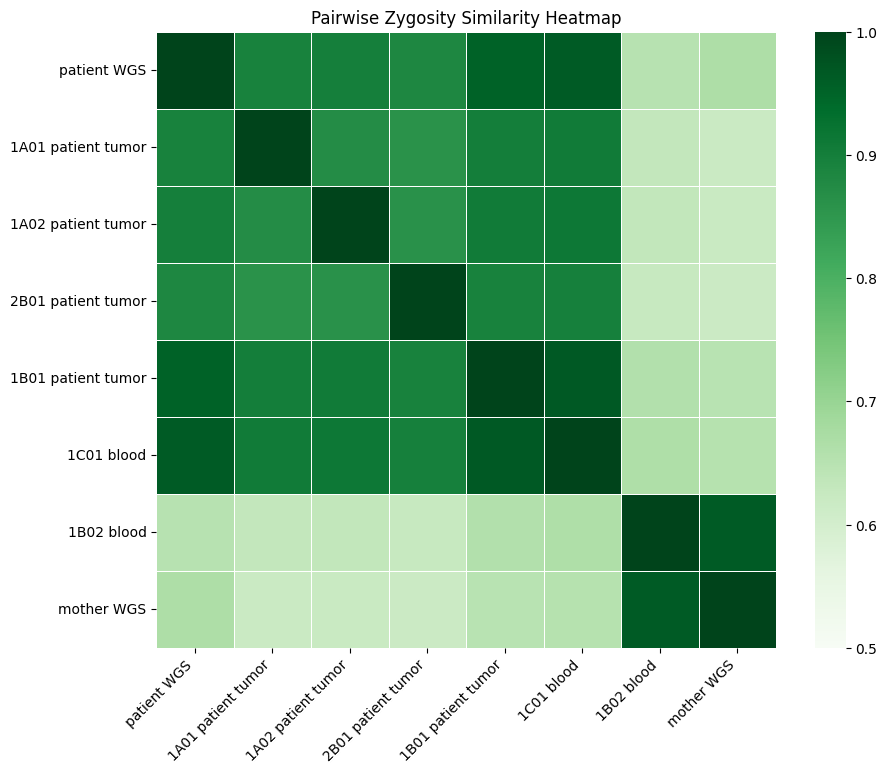

In [ ]:
### this is for plotting of the new samples - assign it correctly now... ###
# define the samples like so using the base dir and the vcfs #
files = {
    "patient WGS": base_dir + "patient_fin.vcf",
    "1A01 patient tumor": base_dir + "s1A01_fin.vcf",
    "1A02 patient tumor": base_dir + "s1A02_fin.vcf",
    "2B01 patient tumor": base_dir + "s2B01_fin.vcf",
    "1B01 patient tumor": base_dir + "s1B01_fin.vcf",
    "1C01 blood": base_dir + "s1C01_fin.vcf",
    "1B02 blood": base_dir + "s1B02_fin.vcf",
    "mother WGS": base_dir + "mom_fin.vcf"
}

# make a similarity matrix like this pairwise
samples = list(files.keys())
similarity_matrix = pd.DataFrame(index=samples, columns=samples, dtype=float)

# i am computing the pairwise similarity using the compute_zygosity_similarity fcn above
# and itertools combination fcn
for s1, s2 in itertools.combinations(samples, 2):
    similarity_score = compute_zygosity_similarity(files[s1], files[s2])

    similarity_matrix.loc[s1, s2] = similarity_score
    similarity_matrix.loc[s2, s1] = similarity_score  # making a symmetrical matrix

# we know that the diagonal (self-similarity) will be identical, I can just put 1
np.fill_diagonal(similarity_matrix.values, 1.0)

# now plot it as a heatmap using the similar green gradient as AlleleIntegrator with the stylish white gaps for clarity
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.astype(float), annot=False, cmap="Greens", linewidths=0.5, vmin=0, vmax=1)
plt.title("Pairwise Zygosity Similarity Heatmap")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


In [ ]:
### since I have several tsv and vcf, I shall convert everything into the same format
# for this I use the bed positions file and extract the chr and positions again

def load_bed(bed_file):
    """load bed file and extract (chr, pos) from columns 1 and 3 (instead of 1 and 2)."""
    bed_positions = set()
    with open(bed_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            chrom, pos = parts[0], int(parts[2])  # Use 3rd column as position
            bed_positions.add((chrom, pos))
    return bed_positions

### here I am loading the tsv files and making dictionaries of the base counts per position
def load_tsv(tsv_file):
    """Load tsv file into a dictionary aggregating base counts per position."""
    data = defaultdict(lambda: {'A': 0, 'C': 0, 'G': 0, 'T': 0})
    df = pd.read_csv(tsv_file, sep='\t')

    for _, row in df.iterrows():
        key = (f'chr{row["chr"]}', row["pos"])
        for base in ['A', 'C', 'G', 'T']:
            data[key][base] += row[base]

    return data

### then I convert the sampled tsv files and the bed file into a vcf format so I can compare 
def convert_to_vcf(bed_positions, tsv_data):
    """Convert aggregated TSV data and BED positions into VCF format."""
    vcf_lines = []
    for (chrom, pos) in sorted(bed_positions):
        base_counts = tsv_data.get((chrom, pos), {'A': 0, 'C': 0, 'G': 0, 'T': 0})
        total_reads = sum(base_counts.values())
        if total_reads == 0:
            # if no reads are found, use placeholder <*> with zero counts
            continue  # skip lines with no data
        ### I am finding both the reference and alternative bases and adding * whenever missing
        # select reference base: most frequent, breaking ties by 'A > C > G > T' order
        ref_base = max(base_counts, key=lambda b: (base_counts[b], "ACGT".index(b)))
        if ref_base == "N":
            continue  # skip lines where ref_base is 'N'
        # find alternative alleles (excluding reference)
        alt_bases = [b for b in "ACGT" if b != ref_base and base_counts[b] > 0]
        # add <*> allele for missing variants
        alleles = [ref_base] + alt_bases + ["<*>"]
        # ensure <*> gets a count of 0 if not present
        # counting * as a zero
        depth_counts = [base_counts.get(b, 0) for b in alleles]
        freq_values = [f"{count / total_reads:.3f}" for count in depth_counts]
        vcf_lines.append(f"{chrom}\t{pos}\t{ref_base}\t{','.join(alt_bases + ['<*>'])}\t{','.join(map(str, depth_counts))}\t{'  '.join(freq_values)}")
    return vcf_lines

# this is the main function which uses the previous ones to convert the downsampled sc/sn RNA tsv into vcf
def main(tsv_file, bed_file, output_file):
    bed_positions = load_bed(bed_file)
    tsv_data = load_tsv(tsv_file)
    vcf_lines = convert_to_vcf(bed_positions, tsv_data)
    with open(output_file, 'w') as f:
        f.write('\n'.join(vcf_lines) + '\n')
    print(f"VCF file saved to {output_file}")

# then I use it like this for the downsampled tsv files for single nuclear/single cell data
# main("input.tsv", "positions.bed", "output.vcf")
main(base_dir + "patient tumor FO CG_SB_NB13960948_genotypeCheck.tsv", base_dir + "patient_output.bed", base_dir + "patient_tumor_FO1.vcf")
main(base_dir + "patient tumor FO CG_SB_NB13960949_genotypeCheck.tsv", base_dir + "patient_output.bed", base_dir + "patient_tumor_FO2.vcf")
main(base_dir + "patient tumor FO CG_SB_NB13960950_genotypeCheck.tsv", base_dir + "patient_output.bed", base_dir + "patient_tumor_FO3.vcf")
main(base_dir + "patient tumor FO CG_SB_NB13960951_genotypeCheck.tsv", base_dir + "patient_output.bed", base_dir + "patient_tumor_FO4.vcf")
main(base_dir + "patient tumor FT CG_SB_NB14449539_genotypeCheck.tsv", base_dir + "patient_output.bed", base_dir + "patient_tumor_FT1.vcf")
main(base_dir + "patient tumor FT CG_SB_NB14449540_genotypeCheck.tsv", base_dir + "patient_output.bed", base_dir + "patient_tumor_FT2.vcf")
main(base_dir + "patient tumor FT CG_SB_NB14449541_genotypeCheck.tsv", base_dir + "patient_output.bed", base_dir + "patient_tumor_FT3.vcf")
main(base_dir + "Ewings-patient_genotypeCheck.tsv", base_dir + "patient_output.bed", base_dir + "Ewings_patient.vcf")
main(base_dir + "patient-bulk-DNA-un_genotypeCheck.tsv", base_dir + "patient_output.bed", base_dir + "patient_PD54858b.vcf")

In [ ]:
### this is a very similar situation with the standard compute_zygosity_similarity function
# but this one weights the positions with higher read depth as better
# the reason for this is that I am using generally shallow sn/sc RNA files to compare with 
# high depth WGS and HiFi files so I also want to show the effect that sn/sc shallowness with Illumina
# non-HiFi reads has
def compute_zygosity_similarity_weighted(file1, file2):
    """
    computes the weighted zygosity similarity between two files, giving more
    influence to positions with higher read depth.

    Parameters:
        file1 (str): Path to the first file.
        file2 (str): Path to the second file.

    Returns:
        float: Weighted zygosity similarity score.
    """
    # read files into dataframes
    df1 = pd.read_csv(file1, sep="\t", header=None,
                      names=["CHROM", "POS", "REF", "ALT", "AD", "REF_FREQ", "ALT_FREQ", "OTHER_FREQ", "OTHER_FREQ1"])

    df2 = pd.read_csv(file2, sep="\t", header=None,
                      names=["CHROM", "POS", "REF", "ALT", "AD", "REF_FREQ", "ALT_FREQ", "OTHER_FREQ", "OTHER_FREQ1"])

# again merge based on chr and positions that are the same
    merged_df = pd.merge(df1, df2, on=["CHROM", "POS"], suffixes=("_file1", "_file2"))
    # fill those missing with 0s
    merged_df.fillna(0, inplace=True)
    # find the most abundant allele frequency at each site
    merged_df["MAF_file1"] = merged_df[["REF_FREQ_file1", "ALT_FREQ_file1", "OTHER_FREQ_file1"]].max(axis=1)
    merged_df["MAF_file2"] = merged_df[["REF_FREQ_file2", "ALT_FREQ_file2", "OTHER_FREQ_file2"]].max(axis=1)
    # again define zygosity categories homozygous (>= 0.9 or <= 0.1) vs. heterozygous 
    # note that this will work because if it is heterozygous we are still getting max of around 0.5
    # also accounts for whole chromosomal copy number changes in tumor samples
    def determine_zygosity(freq):
        if freq >= 0.9 or freq <= 0.1:
            return "HET"
        else:
            return "HOMO"

    merged_df["ZYGOSITY_file1"] = merged_df["MAF_file1"].apply(determine_zygosity)
    merged_df["ZYGOSITY_file2"] = merged_df["MAF_file2"].apply(determine_zygosity)
    # here is where it differs from the previous function 
    # compute total read depth from AD column
    merged_df["TOTAL_DEPTH_file1"] = merged_df["AD_file1"].apply(lambda x: sum(map(int, str(x).replace(" ", ",").strip().split(","))) if str(x).strip() else 0)
    merged_df["TOTAL_DEPTH_file2"] = merged_df["AD_file2"].apply(lambda x: sum(map(int, str(x).replace(" ", ",").strip().split(","))) if str(x).strip() else 0)
    # compute combined total depth per position
    merged_df["TOTAL_DEPTH"] = merged_df["TOTAL_DEPTH_file1"] + merged_df["TOTAL_DEPTH_file2"]
    # normalize weights so that all positions contribute proportionally depending on depth
    total_depth_sum = merged_df["TOTAL_DEPTH"].sum()
    merged_df["WEIGHT"] = merged_df["TOTAL_DEPTH"] / total_depth_sum if total_depth_sum > 0 else 0

    # again counting the weighted similarity: sum of weights where zygosity matches
    weighted_similarity = (merged_df["WEIGHT"] * (merged_df["ZYGOSITY_file1"] == merged_df["ZYGOSITY_file2"])).sum()
    return weighted_similarity

# again here define a dictionary mapping sample names to file paths
files = {
    "patient WGS PD54858d": base_dir + "patient_fin.vcf",
    "patient WGS PD54858b": base_dir + "patient_PD54858b.vcf",
    "1A01 Sequel II patient tumor": base_dir + "s1A01_fin.vcf",
    "1A02 Sequel II patient tumor": base_dir + "s1A02_fin.vcf",
    "2B01 Sequel II patient tumor": base_dir + "s2B01_fin.vcf",
    "1B01 Revio patient tumor": base_dir + "s1B01_fin.vcf",
    "1C01 Revio patient blood": base_dir + "s1C01_fin.vcf",
    "patient snRNA tumor FO1": base_dir + "patient_tumor_FO1.vcf",
    "patient snRNA tumor FO2": base_dir + "patient_tumor_FO2.vcf",
    "patient snRNA tumor FO3": base_dir + "patient_tumor_FO3.vcf",
    "patient snRNA tumor FO4": base_dir + "patient_tumor_FO4.vcf",
    "patient snRNA tumor FT1": base_dir + "patient_tumor_FT1.vcf",
    "patient snRNA tumor FT2": base_dir + "patient_tumor_FT2.vcf",
    "patient snRNA tumor FT3": base_dir + "patient_tumor_FT3.vcf",
    "mother WGS PD54859b": base_dir + "mom_fin.vcf",
    "1B02 Revio mother blood": base_dir + "s1B02_fin.vcf",
    "Ewings scRNA patient": base_dir + "Ewings_patient.vcf"
}

# again make the similarity matrix
samples = list(files.keys())
similarity_matrix = pd.DataFrame(index=samples, columns=samples, dtype=float)

# and compute pairwise zygosity similarity using only common loci - note there are
# different files sharing different sampled locs
for s1, s2 in itertools.combinations(samples, 2):
    similarity_score = compute_zygosity_similarity_weighted(files[s1], files[s2])

    similarity_matrix.loc[s1, s2] = similarity_score
    similarity_matrix.loc[s2, s1] = similarity_score  # symmetric matrix

# again fill diagonal with 1s - self
np.fill_diagonal(similarity_matrix.values, 1.0)

# plot the green heatmap with the green edges and name it and save it
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.astype(float), annot=False, cmap="Greens", linewidths=0, vmin=0, vmax=1)
plt.title("Pairwise Zygosity Similarity Heatmap")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.savefig(base_dir + "pairwise_similarity_map.pdf", dpi=300, bbox_inches='tight')

NameError: name 'base_dir' is not defined